<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB2.001'
datasets_dir = pwk.init('GTSRB2', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB2_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : GTSRB2
Run time             : Monday 01 March 2021, 18:48:25
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB2_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB2_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1



Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 417ms)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


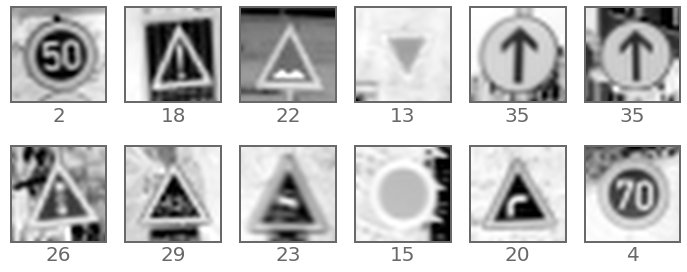

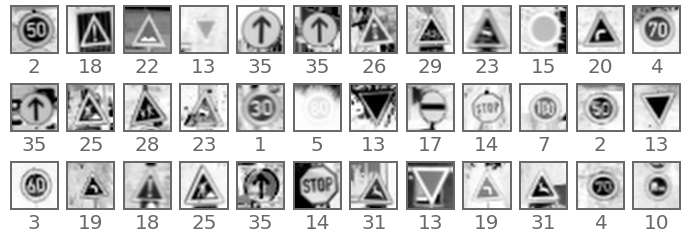

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

**Train it :**

In [9]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 29:47 - loss: 3.7620 - accuracy: 0.0000e+00

 19/613 [..............................] - ETA: 1s - loss: 3.6511 - accuracy: 0.0539       

 38/613 [>.............................] - ETA: 1s - loss: 3.6190 - accuracy: 0.0573

 57/613 [=>............................] - ETA: 1s - loss: 3.5909 - accuracy: 0.0622

 76/613 [==>...........................] - ETA: 1s - loss: 3.5593 - accuracy: 0.0710

 95/613 [===>..........................] - ETA: 1s - loss: 3.5176 - accuracy: 0.0823

114/613 [====>.........................] - ETA: 1s - loss: 3.4677 - accuracy: 0.0956

133/613 [=====>........................] - ETA: 1s - loss: 3.4108 - accuracy: 0.1106

153/613 [======>.......................] - ETA: 1s - loss: 3.3455 - accuracy: 0.1272

173/613 [=======>......................] - ETA: 1s - loss: 3.2770 - accuracy: 0.1440

193/613 [========>.....................] - ETA: 1s - loss: 3.2071 - accuracy: 0.1610

213/613 [=========>....................] - ETA: 1s - loss: 3.1378 - accuracy: 0.1778

233/613 [==========>...................] - ETA: 1s - loss: 3.0700 - accuracy: 0.1942

253/613 [===========>..................] - ETA: 0s - loss: 3.0043 - accuracy: 0.2102

273/613 [============>.................] - ETA: 0s - loss: 2.9411 - accuracy: 0.2256

293/613 [=============>................] - ETA: 0s - loss: 2.8803 - accuracy: 0.2404

313/613 [==============>...............] - ETA: 0s - loss: 2.8223 - accuracy: 0.2547

333/613 [===============>..............] - ETA: 0s - loss: 2.7668 - accuracy: 0.2685

353/613 [================>.............] - ETA: 0s - loss: 2.7137 - accuracy: 0.2817

373/613 [=================>............] - ETA: 0s - loss: 2.6630 - accuracy: 0.2943

393/613 [==================>...........] - ETA: 0s - loss: 2.6145 - accuracy: 0.3065

413/613 [===================>..........] - ETA: 0s - loss: 2.5681 - accuracy: 0.3181

433/613 [====================>.........] - ETA: 0s - loss: 2.5236 - accuracy: 0.3293

453/613 [=====================>........] - ETA: 0s - loss: 2.4808 - accuracy: 0.3402

473/613 [======================>.......] - ETA: 0s - loss: 2.4398 - accuracy: 0.3506

493/613 [=======================>......] - ETA: 0s - loss: 2.4004 - accuracy: 0.3605

513/613 [========================>.....] - ETA: 0s - loss: 2.3625 - accuracy: 0.3702

533/613 [=========================>....] - ETA: 0s - loss: 2.3260 - accuracy: 0.3795

553/613 [==========================>...] - ETA: 0s - loss: 2.2909 - accuracy: 0.3884

573/613 [===========================>..] - ETA: 0s - loss: 2.2570 - accuracy: 0.3971

593/613 [============================>.] - ETA: 0s - loss: 2.2244 - accuracy: 0.4055

613/613 [==============================] - ETA: 0s - loss: 2.1929 - accuracy: 0.4136

613/613 [==============================] - 6s 5ms/step - loss: 2.1913 - accuracy: 0.4140 - val_loss: 0.4812 - val_accuracy: 0.8812


Epoch 2/5
  1/613 [..............................] - ETA: 1s - loss: 0.1433 - accuracy: 1.0000

 21/613 [>.............................] - ETA: 1s - loss: 0.3052 - accuracy: 0.9233

 41/613 [=>............................] - ETA: 1s - loss: 0.3181 - accuracy: 0.9156

 61/613 [=>............................] - ETA: 1s - loss: 0.3231 - accuracy: 0.9118

 81/613 [==>...........................] - ETA: 1s - loss: 0.3255 - accuracy: 0.9099

101/613 [===>..........................] - ETA: 1s - loss: 0.3248 - accuracy: 0.9092

121/613 [====>.........................] - ETA: 1s - loss: 0.3232 - accuracy: 0.9092

141/613 [=====>........................] - ETA: 1s - loss: 0.3217 - accuracy: 0.9093

161/613 [======>.......................] - ETA: 1s - loss: 0.3204 - accuracy: 0.9096

181/613 [=======>......................] - ETA: 1s - loss: 0.3190 - accuracy: 0.9099

201/613 [========>.....................] - ETA: 1s - loss: 0.3173 - accuracy: 0.9102

221/613 [=========>....................] - ETA: 1s - loss: 0.3155 - accuracy: 0.9106

241/613 [==========>...................] - ETA: 0s - loss: 0.3138 - accuracy: 0.9109

261/613 [===========>..................] - ETA: 0s - loss: 0.3122 - accuracy: 0.9113

281/613 [============>.................] - ETA: 0s - loss: 0.3103 - accuracy: 0.9117

301/613 [=============>................] - ETA: 0s - loss: 0.3084 - accuracy: 0.9121

321/613 [==============>...............] - ETA: 0s - loss: 0.3064 - accuracy: 0.9126

341/613 [===============>..............] - ETA: 0s - loss: 0.3045 - accuracy: 0.9130

361/613 [================>.............] - ETA: 0s - loss: 0.3027 - accuracy: 0.9135

381/613 [=================>............] - ETA: 0s - loss: 0.3010 - accuracy: 0.9139

401/613 [==================>...........] - ETA: 0s - loss: 0.2992 - accuracy: 0.9143

421/613 [===================>..........] - ETA: 0s - loss: 0.2974 - accuracy: 0.9148

441/613 [====================>.........] - ETA: 0s - loss: 0.2956 - accuracy: 0.9152

461/613 [=====================>........] - ETA: 0s - loss: 0.2939 - accuracy: 0.9157

481/613 [======================>.......] - ETA: 0s - loss: 0.2922 - accuracy: 0.9161

501/613 [=======================>......] - ETA: 0s - loss: 0.2905 - accuracy: 0.9166

521/613 [========================>.....] - ETA: 0s - loss: 0.2888 - accuracy: 0.9170

541/613 [=========================>....] - ETA: 0s - loss: 0.2872 - accuracy: 0.9175

561/613 [==========================>...] - ETA: 0s - loss: 0.2857 - accuracy: 0.9179

581/613 [===========================>..] - ETA: 0s - loss: 0.2841 - accuracy: 0.9184

601/613 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.9188

613/613 [==============================] - 2s 3ms/step - loss: 0.2814 - accuracy: 0.9191 - val_loss: 0.3312 - val_accuracy: 0.9226


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.0854 - accuracy: 0.9844

 21/613 [>.............................] - ETA: 1s - loss: 0.1422 - accuracy: 0.9701

 41/613 [=>............................] - ETA: 1s - loss: 0.1455 - accuracy: 0.9653

 61/613 [=>............................] - ETA: 1s - loss: 0.1458 - accuracy: 0.9636

 81/613 [==>...........................] - ETA: 1s - loss: 0.1450 - accuracy: 0.9629

101/613 [===>..........................] - ETA: 1s - loss: 0.1449 - accuracy: 0.9622

121/613 [====>.........................] - ETA: 1s - loss: 0.1447 - accuracy: 0.9620

141/613 [=====>........................] - ETA: 1s - loss: 0.1445 - accuracy: 0.9619

160/613 [======>.......................] - ETA: 1s - loss: 0.1441 - accuracy: 0.9618

179/613 [=======>......................] - ETA: 1s - loss: 0.1440 - accuracy: 0.9617

198/613 [========>.....................] - ETA: 1s - loss: 0.1438 - accuracy: 0.9616

217/613 [=========>....................] - ETA: 1s - loss: 0.1437 - accuracy: 0.9615

237/613 [==========>...................] - ETA: 0s - loss: 0.1433 - accuracy: 0.9614

257/613 [===========>..................] - ETA: 0s - loss: 0.1430 - accuracy: 0.9614

277/613 [============>.................] - ETA: 0s - loss: 0.1426 - accuracy: 0.9614

297/613 [=============>................] - ETA: 0s - loss: 0.1421 - accuracy: 0.9614

317/613 [==============>...............] - ETA: 0s - loss: 0.1417 - accuracy: 0.9614

337/613 [===============>..............] - ETA: 0s - loss: 0.1413 - accuracy: 0.9614

357/613 [================>.............] - ETA: 0s - loss: 0.1409 - accuracy: 0.9615

377/613 [=================>............] - ETA: 0s - loss: 0.1404 - accuracy: 0.9615

397/613 [==================>...........] - ETA: 0s - loss: 0.1400 - accuracy: 0.9616

417/613 [===================>..........] - ETA: 0s - loss: 0.1396 - accuracy: 0.9616

437/613 [====================>.........] - ETA: 0s - loss: 0.1392 - accuracy: 0.9616

457/613 [=====================>........] - ETA: 0s - loss: 0.1388 - accuracy: 0.9617

477/613 [======================>.......] - ETA: 0s - loss: 0.1385 - accuracy: 0.9617

497/613 [=======================>......] - ETA: 0s - loss: 0.1382 - accuracy: 0.9617

517/613 [========================>.....] - ETA: 0s - loss: 0.1380 - accuracy: 0.9617

537/613 [=========================>....] - ETA: 0s - loss: 0.1377 - accuracy: 0.9617

557/613 [==========================>...] - ETA: 0s - loss: 0.1374 - accuracy: 0.9617

577/613 [===========================>..] - ETA: 0s - loss: 0.1372 - accuracy: 0.9617

597/613 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9617

613/613 [==============================] - 2s 3ms/step - loss: 0.1367 - accuracy: 0.9618 - val_loss: 0.2893 - val_accuracy: 0.9329


Epoch 4/5
  1/613 [..............................] - ETA: 1s - loss: 0.1459 - accuracy: 0.9531

 20/613 [..............................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9735

 39/613 [>.............................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9714

 58/613 [=>............................] - ETA: 1s - loss: 0.1006 - accuracy: 0.9707

 77/613 [==>...........................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9706

 96/613 [===>..........................] - ETA: 1s - loss: 0.1016 - accuracy: 0.9704

115/613 [====>.........................] - ETA: 1s - loss: 0.1014 - accuracy: 0.9704

134/613 [=====>........................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9704

153/613 [======>.......................] - ETA: 1s - loss: 0.1008 - accuracy: 0.9705

172/613 [=======>......................] - ETA: 1s - loss: 0.1004 - accuracy: 0.9707

191/613 [========>.....................] - ETA: 1s - loss: 0.1001 - accuracy: 0.9707

210/613 [=========>....................] - ETA: 1s - loss: 0.0999 - accuracy: 0.9708

229/613 [==========>...................] - ETA: 1s - loss: 0.0997 - accuracy: 0.9708

248/613 [===========>..................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9707

267/613 [============>.................] - ETA: 0s - loss: 0.0995 - accuracy: 0.9707

286/613 [============>.................] - ETA: 0s - loss: 0.0993 - accuracy: 0.9707

306/613 [=============>................] - ETA: 0s - loss: 0.0991 - accuracy: 0.9707

325/613 [==============>...............] - ETA: 0s - loss: 0.0988 - accuracy: 0.9707

344/613 [===============>..............] - ETA: 0s - loss: 0.0985 - accuracy: 0.9707

363/613 [================>.............] - ETA: 0s - loss: 0.0983 - accuracy: 0.9707

382/613 [=================>............] - ETA: 0s - loss: 0.0980 - accuracy: 0.9708

401/613 [==================>...........] - ETA: 0s - loss: 0.0977 - accuracy: 0.9708

420/613 [===================>..........] - ETA: 0s - loss: 0.0974 - accuracy: 0.9709

439/613 [====================>.........] - ETA: 0s - loss: 0.0971 - accuracy: 0.9709

458/613 [=====================>........] - ETA: 0s - loss: 0.0969 - accuracy: 0.9710

478/613 [======================>.......] - ETA: 0s - loss: 0.0966 - accuracy: 0.9710

497/613 [=======================>......] - ETA: 0s - loss: 0.0964 - accuracy: 0.9711

516/613 [========================>.....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9711

535/613 [=========================>....] - ETA: 0s - loss: 0.0959 - accuracy: 0.9712

554/613 [==========================>...] - ETA: 0s - loss: 0.0957 - accuracy: 0.9713

573/613 [===========================>..] - ETA: 0s - loss: 0.0955 - accuracy: 0.9713

592/613 [===========================>..] - ETA: 0s - loss: 0.0952 - accuracy: 0.9714

611/613 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9714

613/613 [==============================] - 2s 3ms/step - loss: 0.0949 - accuracy: 0.9714 - val_loss: 0.2745 - val_accuracy: 0.9371


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0649 - accuracy: 0.9844

 20/613 [..............................] - ETA: 1s - loss: 0.0764 - accuracy: 0.9793

 39/613 [>.............................] - ETA: 1s - loss: 0.0690 - accuracy: 0.9814

 58/613 [=>............................] - ETA: 1s - loss: 0.0652 - accuracy: 0.9821

 77/613 [==>...........................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9825

 96/613 [===>..........................] - ETA: 1s - loss: 0.0620 - accuracy: 0.9828

115/613 [====>.........................] - ETA: 1s - loss: 0.0613 - accuracy: 0.9829

134/613 [=====>........................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9829

153/613 [======>.......................] - ETA: 1s - loss: 0.0609 - accuracy: 0.9829

172/613 [=======>......................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9829

191/613 [========>.....................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9828

210/613 [=========>....................] - ETA: 1s - loss: 0.0610 - accuracy: 0.9828

229/613 [==========>...................] - ETA: 1s - loss: 0.0612 - accuracy: 0.9827

248/613 [===========>..................] - ETA: 0s - loss: 0.0614 - accuracy: 0.9826

267/613 [============>.................] - ETA: 0s - loss: 0.0617 - accuracy: 0.9825

286/613 [============>.................] - ETA: 0s - loss: 0.0619 - accuracy: 0.9823

306/613 [=============>................] - ETA: 0s - loss: 0.0622 - accuracy: 0.9822

325/613 [==============>...............] - ETA: 0s - loss: 0.0625 - accuracy: 0.9821

345/613 [===============>..............] - ETA: 0s - loss: 0.0627 - accuracy: 0.9820

365/613 [================>.............] - ETA: 0s - loss: 0.0629 - accuracy: 0.9819

385/613 [=================>............] - ETA: 0s - loss: 0.0630 - accuracy: 0.9818

405/613 [==================>...........] - ETA: 0s - loss: 0.0631 - accuracy: 0.9818

425/613 [===================>..........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

445/613 [====================>.........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

465/613 [=====================>........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

485/613 [======================>.......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

505/613 [=======================>......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

525/613 [========================>.....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9817

545/613 [=========================>....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9816

565/613 [==========================>...] - ETA: 0s - loss: 0.0633 - accuracy: 0.9816

585/613 [===========================>..] - ETA: 0s - loss: 0.0633 - accuracy: 0.9816

605/613 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9816

613/613 [==============================] - 2s 3ms/step - loss: 0.0634 - accuracy: 0.9816 - val_loss: 0.2507 - val_accuracy: 0.9433



Duration :  00:00:14 747ms


## Step 5 - Evaluate

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9433


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2507
Test accuracy  : 0.9433


In [12]:
pwk.end()

End time is : Monday 01 March 2021, 18:48:48
Duration is : 00:00:23 057ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>